In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import joblib
from datetime import datetime

In [91]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [92]:
df = pd.read_csv("../../data/raw/winequality-red.csv")
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [93]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData Info:")
print(df.info())

print(f"\nStatistical Summary:")
print(df.describe())

Dataset shape: (1599, 12)

Column names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First 5 rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65

In [94]:
# Check missing values
print(f"\nMissing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found!")


Missing values:
No missing values found!


In [95]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 240


Exploratory Data Analysis (EDA)

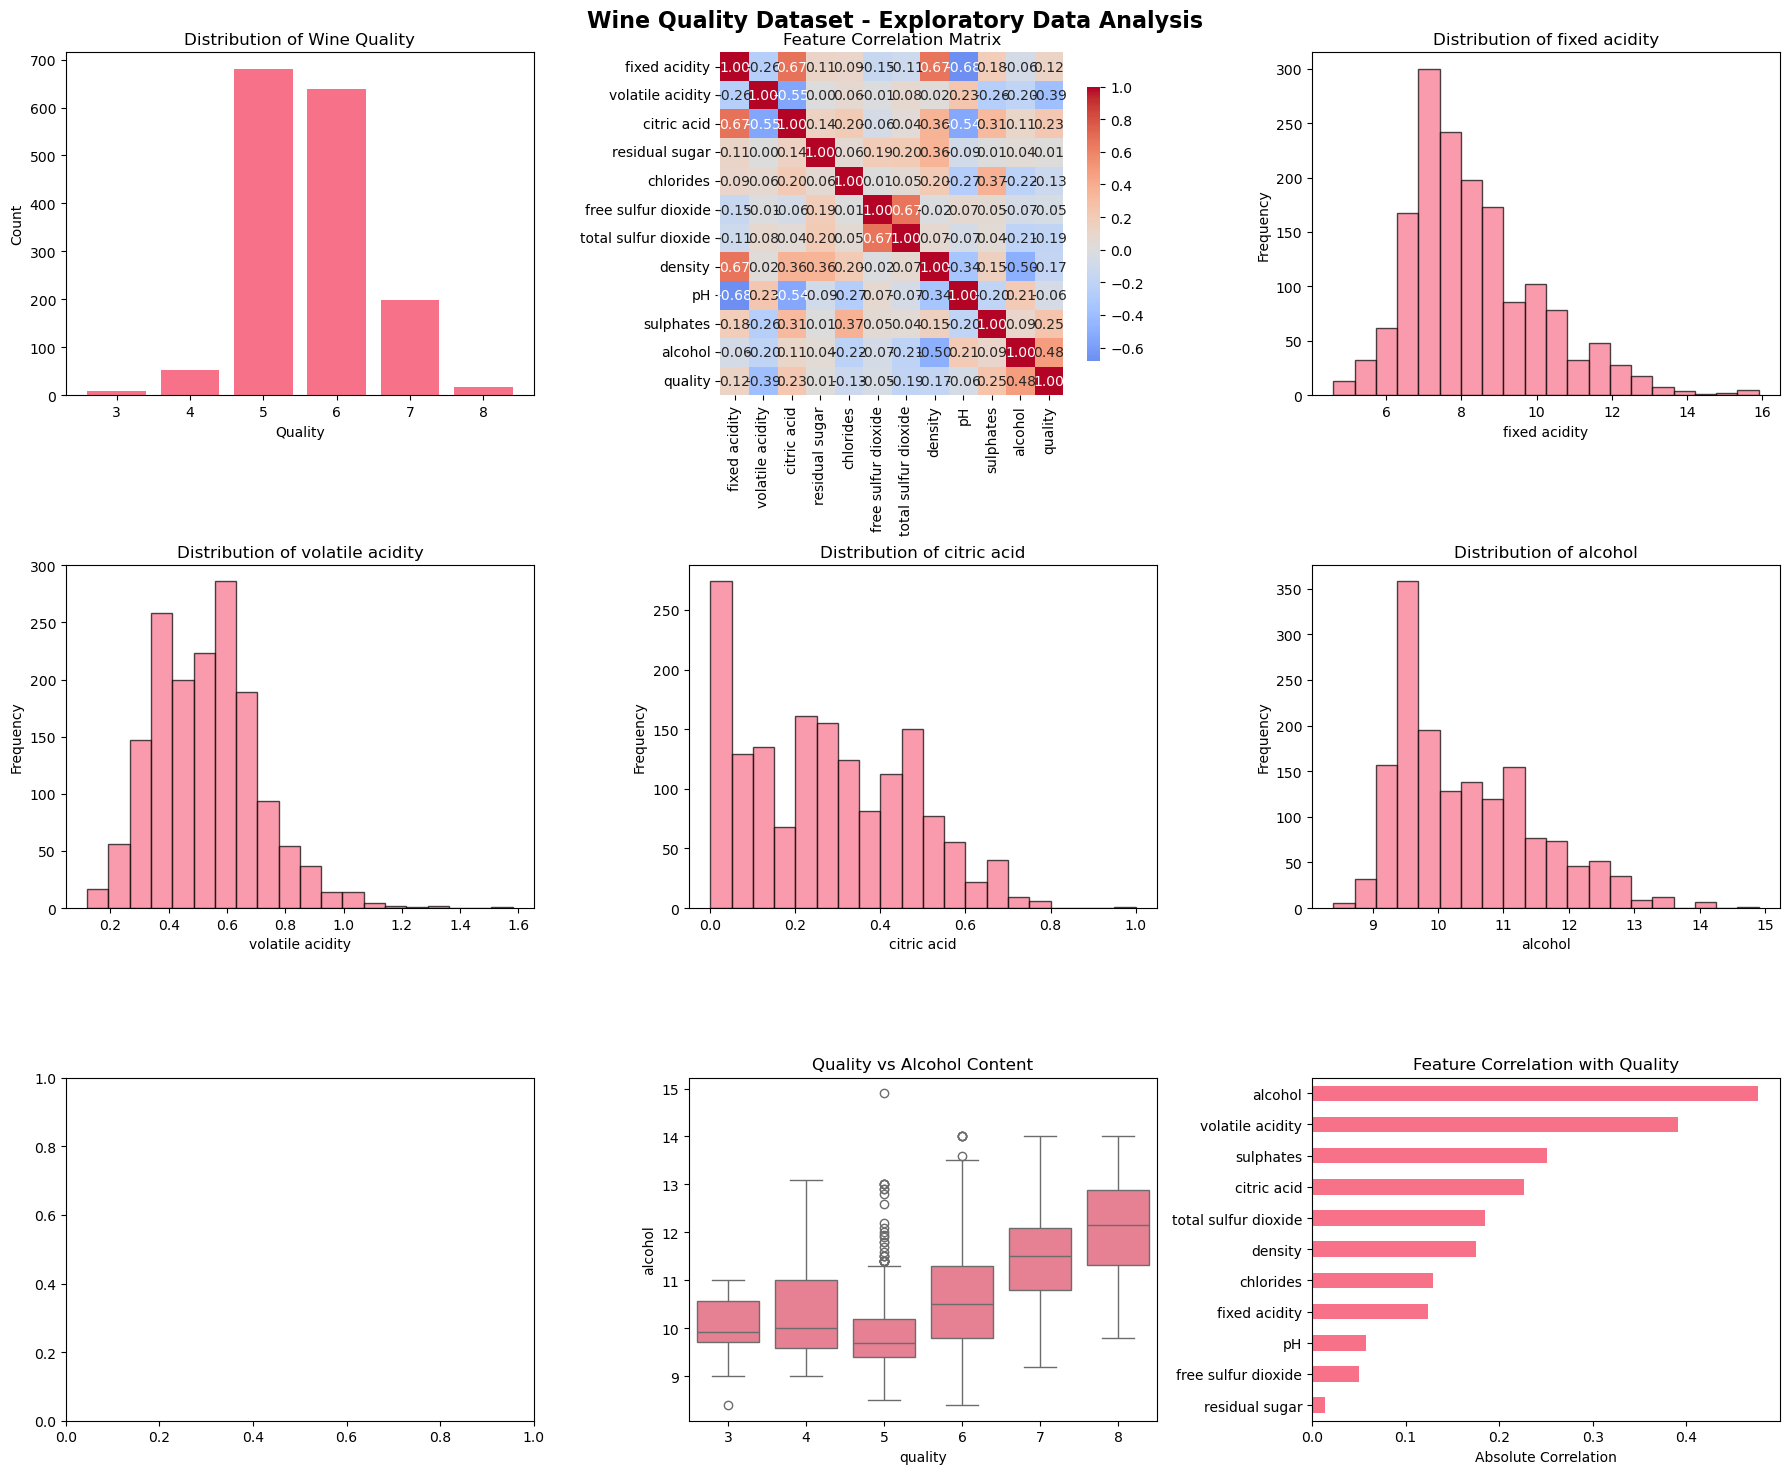


EDA INSIGHTS:
- Quality range: 3 to 8
- Most common quality: 5
- Average quality: 5.64
- Features most correlated with quality:
  * alcohol: 0.476
  * volatile acidity: -0.391
  * sulphates: 0.251


In [96]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Wine Quality Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1.Quality distribution
axes[0, 0].bar(df['quality'].value_counts().sort_index().index, 
               df['quality'].value_counts().sort_index().values)
axes[0, 0].set_title('Distribution of Wine Quality')
axes[0, 0].set_xlabel('Quality')
axes[0, 0].set_ylabel('Count')

# 2.Correlation heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, fmt='.2f', ax=axes[0, 1], cbar_kws={'shrink': 0.8})
axes[0, 1].set_title('Feature Correlation Matrix')

# 3.Key feature distributions
features_to_plot = ['fixed acidity', 'volatile acidity', 'citric acid', 'alcohol']
for i, feature in enumerate(features_to_plot):
    row = (i + 2) // 3
    col = (i + 2) % 3
    axes[row, col].hist(df[feature], bins=20, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

# 7.Box plot for quality vs alcohol
sns.boxplot(data=df, x='quality', y='alcohol', ax=axes[2, 1])
axes[2, 1].set_title('Quality vs Alcohol Content')

# 8.Feature importance preview (correlation with quality)
feature_importance = abs(correlation_matrix['quality'].drop('quality')).sort_values(ascending=True)
feature_importance.plot(kind='barh', ax=axes[2, 2])
axes[2, 2].set_title('Feature Correlation with Quality')
axes[2, 2].set_xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()

# Print insights
print(f"\nEDA INSIGHTS:")
print(f"- Quality range: {df['quality'].min()} to {df['quality'].max()}")
print(f"- Most common quality: {df['quality'].mode()[0]}")
print(f"- Average quality: {df['quality'].mean():.2f}")
print(f"- Features most correlated with quality:")
quality_corr = correlation_matrix['quality'].drop('quality').sort_values(key=abs, ascending=False)
for feature, corr in quality_corr.head(3).items():
    print(f"  * {feature}: {corr:.3f}")

Data Cleaning

In [97]:
initial_shape = df.shape
print(f"Initial dataset shape: {initial_shape}")

Initial dataset shape: (1599, 12)


In [98]:
# Remove duplicates
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")

After removing duplicates: (1359, 12)


In [60]:
# Handle missing values (No any missing values hear)
if df_clean.isnull().sum().sum() > 0:
    print("Handling missing values...")
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numerical_cols] = df_clean[numerical_cols].fillna(df_clean[numerical_cols].median())
    print("Missing values filled with median")

Feature Preparation

In [61]:
feature_names = [col for col in df_clean.columns if col != 'quality']
target_name = 'quality'

X = df_clean[feature_names]
y = df_clean[target_name]

print(f"Number of features: {len(feature_names)}")
print(f"Features: {feature_names}")
print(f"Target: {target_name}")
print(f"Target classes: {sorted(y.unique())}")

Number of features: 11
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Target: quality
Target classes: [3, 4, 5, 6, 7, 8]


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set target distribution:\n{y_train.value_counts().sort_index()}")
print(f"Test set target distribution:\n{y_test.value_counts().sort_index()}")


Training set shape: (1087, 11)
Test set shape: (272, 11)
Training set target distribution:
quality
3      8
4     42
5    461
6    428
7    134
8     14
Name: count, dtype: int64
Test set target distribution:
quality
3      2
4     11
5    116
6    107
7     33
8      3
Name: count, dtype: int64


In [64]:
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Grid search for best parameters
print("Performing hyperparameter optimization for Decision Tree...")
dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train, y_train)

Performing hyperparameter optimization for Decision Tree...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy', verbose=1)

In [65]:
best_dt_model = dt_grid_search.best_estimator_

print(f"\nBest Decision Tree parameters: {dt_grid_search.best_params_}")
print(f"Best cross-validation score: {dt_grid_search.best_score_:.4f}")


Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.5676


In [66]:
dt_train_pred = best_dt_model.predict(X_train)
dt_test_pred = best_dt_model.predict(X_test)

In [67]:
dt_train_accuracy = accuracy_score(y_train, dt_train_pred)
dt_test_accuracy = accuracy_score(y_test, dt_test_pred)

print(f"\nDecision Tree Results:")
print(f"Training Accuracy: {dt_train_accuracy:.4f}")
print(f"Test Accuracy: {dt_test_accuracy:.4f}")


Decision Tree Results:
Training Accuracy: 0.6348
Test Accuracy: 0.6250


In [68]:
dt_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Important Features (Decision Tree):")
print(dt_feature_importance.head())


Top 5 Important Features (Decision Tree):
                 feature  importance
10               alcohol    0.448101
9              sulphates    0.183160
1       volatile acidity    0.136101
6   total sulfur dioxide    0.101457
5    free sulfur dioxide    0.058944


Random Forest Training with Hyperparameter Optimization

In [69]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

print("Performing hyperparameter optimization for Random Forest...")
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)


Performing hyperparameter optimization for Random Forest...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [70]:
# Best model
best_rf_model = rf_grid_search.best_estimator_

print(f"\nBest Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation score: {rf_grid_search.best_score_:.4f}")


Best Random Forest parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.6099


In [71]:
rf_train_pred = best_rf_model.predict(X_train)
rf_test_pred = best_rf_model.predict(X_test)

In [72]:
rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)

print(f"\nRandom Forest Results:")
print(f"Training Accuracy: {rf_train_accuracy:.4f}")
print(f"Test Accuracy: {rf_test_accuracy:.4f}")


Random Forest Results:
Training Accuracy: 0.8850
Test Accuracy: 0.6434


In [73]:
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Important Features (Random Forest):")
print(rf_feature_importance.head())


Top 5 Important Features (Random Forest):
                 feature  importance
10               alcohol    0.169395
9              sulphates    0.122060
1       volatile acidity    0.116195
6   total sulfur dioxide    0.108012
7                density    0.084832


Model Evaluation and Comparison

In [74]:
# Decision Tree detailed evaluation
print("DECISION TREE DETAILED RESULTS:")
print("Classification Report:")
print(classification_report(y_test, dt_test_pred))

print("\nConfusion Matrix:")
dt_cm = confusion_matrix(y_test, dt_test_pred)
print(dt_cm)

DECISION TREE DETAILED RESULTS:
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.66      0.83      0.74       116
           6       0.58      0.53      0.56       107
           7       0.59      0.52      0.55        33
           8       0.00      0.00      0.00         3

    accuracy                           0.62       272
   macro avg       0.30      0.31      0.31       272
weighted avg       0.58      0.62      0.60       272


Confusion Matrix:
[[ 0  0  2  0  0  0]
 [ 0  0  4  7  0  0]
 [ 0  0 96 20  0  0]
 [ 0  0 40 57 10  0]
 [ 0  0  3 13 17  0]
 [ 0  0  0  1  2  0]]


In [75]:
# Random Forest detailed evaluation
print("RANDOM FOREST DETAILED RESULTS:")
print("Classification Report:")
print(classification_report(y_test, rf_test_pred))

print("\nConfusion Matrix:")
rf_cm = confusion_matrix(y_test, rf_test_pred)
print(rf_cm)

RANDOM FOREST DETAILED RESULTS:
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.73      0.80      0.77       116
           6       0.59      0.66      0.62       107
           7       0.46      0.33      0.39        33
           8       0.00      0.00      0.00         3

    accuracy                           0.64       272
   macro avg       0.30      0.30      0.30       272
weighted avg       0.60      0.64      0.62       272


Confusion Matrix:
[[ 0  0  2  0  0  0]
 [ 0  0  4  7  0  0]
 [ 0  0 93 23  0  0]
 [ 0  0 26 71 10  0]
 [ 0  0  2 20 11  0]
 [ 0  0  0  0  3  0]]


In [76]:
# Model comparison
print("FINAL MODEL COMPARISON:")
print(f"Decision Tree Test Accuracy: {dt_test_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")

FINAL MODEL COMPARISON:
Decision Tree Test Accuracy: 0.6250
Random Forest Test Accuracy: 0.6434


In [77]:
if rf_test_accuracy > dt_test_accuracy:
    best_model = best_rf_model
    best_model_name = "Random Forest"
    best_accuracy = rf_test_accuracy
    print(f"\nüèÜ Random Forest performs better with {best_accuracy:.4f} accuracy!")
else:
    best_model = best_dt_model
    best_model_name = "Decision Tree"
    best_accuracy = dt_test_accuracy
    print(f"\nüèÜ Decision Tree performs better with {best_accuracy:.4f} accuracy!")

print(f"Best model selected: {best_model_name}")


üèÜ Random Forest performs better with 0.6434 accuracy!
Best model selected: Random Forest


Results Visualization

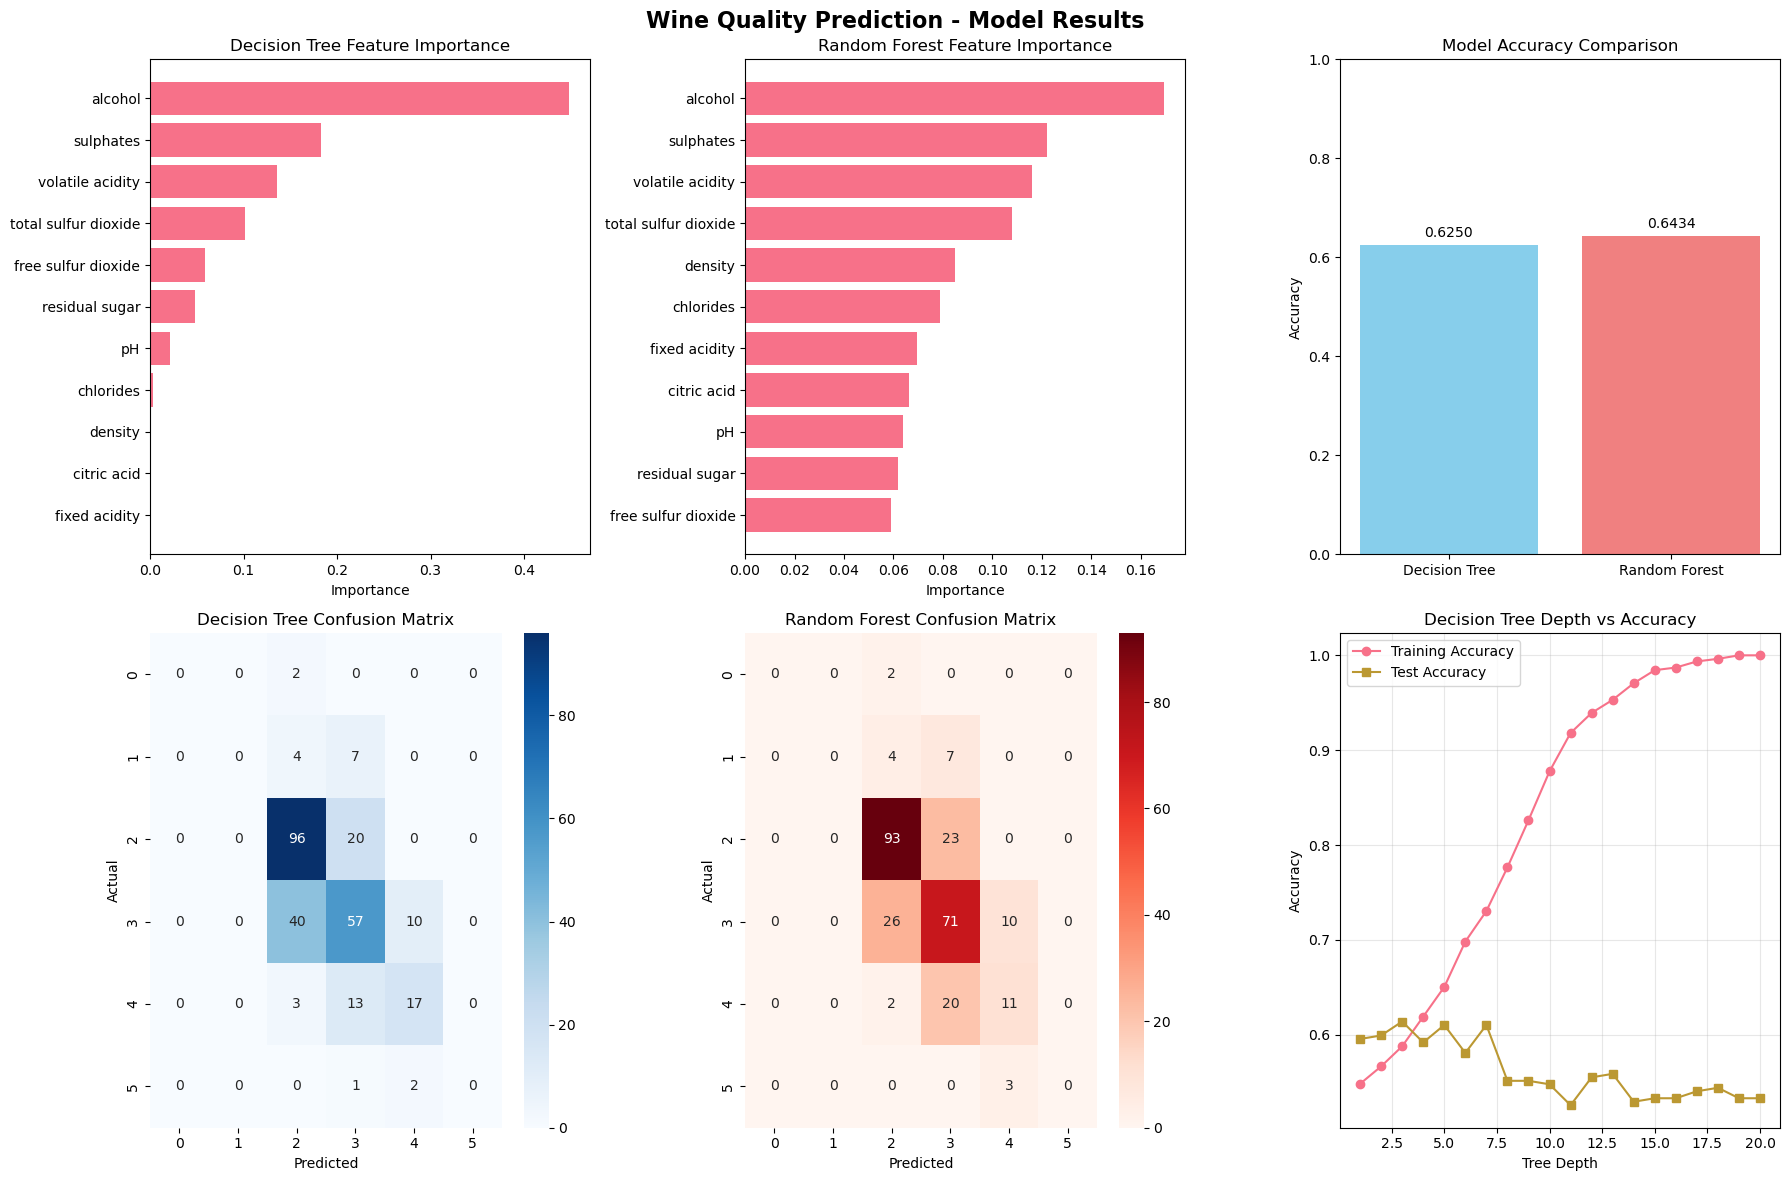


üéØ FINAL RESULTS SUMMARY:
   ‚Ä¢ Best Model: Random Forest
   ‚Ä¢ Best Accuracy: 0.6434
   ‚Ä¢ Dataset Size: 1359 samples
   ‚Ä¢ Features Used: 11


In [78]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Wine Quality Prediction - Model Results', fontsize=16, fontweight='bold')

# 1. Feature importance comparison - Decision Tree
dt_feature_importance_plot = dt_feature_importance.sort_values('importance', ascending=True)
axes[0, 0].barh(dt_feature_importance_plot['feature'], dt_feature_importance_plot['importance'])
axes[0, 0].set_title('Decision Tree Feature Importance')
axes[0, 0].set_xlabel('Importance')

# 2. Feature importance comparison - Random Forest
rf_feature_importance_plot = rf_feature_importance.sort_values('importance', ascending=True)
axes[0, 1].barh(rf_feature_importance_plot['feature'], rf_feature_importance_plot['importance'])
axes[0, 1].set_title('Random Forest Feature Importance')
axes[0, 1].set_xlabel('Importance')

# 3. Accuracy comparison
models = ['Decision Tree', 'Random Forest']
accuracies = [dt_test_accuracy, rf_test_accuracy]
bars = axes[0, 2].bar(models, accuracies, color=['skyblue', 'lightcoral'])
axes[0, 2].set_title('Model Accuracy Comparison')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_ylim(0, 1)

# Add accuracy values on bars
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{accuracy:.4f}', ha='center', va='bottom')

# 4. Confusion matrix - Decision Tree
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Decision Tree Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 5. Confusion matrix - Random Forest
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1, 1])
axes[1, 1].set_title('Random Forest Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# 6. Tree depth analysis
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)
    train_scores.append(dt_temp.score(X_train, y_train))
    test_scores.append(dt_temp.score(X_test, y_test))

axes[1, 2].plot(depths, train_scores, label='Training Accuracy', marker='o')
axes[1, 2].plot(depths, test_scores, label='Test Accuracy', marker='s')
axes[1, 2].set_xlabel('Tree Depth')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Decision Tree Depth vs Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print(f"\nüéØ FINAL RESULTS SUMMARY:")
print(f"   ‚Ä¢ Best Model: {best_model_name}")
print(f"   ‚Ä¢ Best Accuracy: {best_accuracy:.4f}")
print(f"   ‚Ä¢ Dataset Size: {df_clean.shape[0]} samples")
print(f"   ‚Ä¢ Features Used: {len(feature_names)}")


Prediction Function and Sample Prediction

In [79]:
def predict_wine_quality(wine_features):
    """
    Predict wine quality for new samples
    
    Parameters:
    wine_features: dict, list, or pandas DataFrame
        Wine features for prediction
    
    Returns:
    prediction: int - predicted quality
    probabilities: array - probability for each class
    """
    # Ensure input is in correct format
    if isinstance(wine_features, dict):
        wine_features = pd.DataFrame([wine_features])
    elif isinstance(wine_features, list):
        wine_features = pd.DataFrame([wine_features], columns=feature_names)
    
    # Scale the features
    wine_features_scaled = scaler.transform(wine_features)
    
    # Make prediction
    prediction = best_model.predict(wine_features_scaled)
    prediction_proba = best_model.predict_proba(wine_features_scaled)
    
    return prediction[0], prediction_proba[0]

In [80]:
sample_wine = {
    'fixed acidity': 7.4,
    'volatile acidity': 0.70,
    'citric acid': 0.00,
    'residual sugar': 1.9,
    'chlorides': 0.076,
    'free sulfur dioxide': 11.0,
    'total sulfur dioxide': 34.0,
    'density': 0.9978,
    'pH': 3.51,
    'sulphates': 0.56,
    'alcohol': 9.4
}

print("Sample Wine Features:")
for feature, value in sample_wine.items():
    print(f"  {feature}: {value}")

# Make prediction
predicted_quality, prediction_proba = predict_wine_quality(sample_wine)

print(f"\nüç∑ PREDICTION RESULTS:")
print(f"   ‚Ä¢ Predicted Quality: {predicted_quality}")
print(f"   ‚Ä¢ Prediction Confidence: {max(prediction_proba):.4f}")
print(f"   ‚Ä¢ Model Used: {best_model_name}")

Sample Wine Features:
  fixed acidity: 7.4
  volatile acidity: 0.7
  citric acid: 0.0
  residual sugar: 1.9
  chlorides: 0.076
  free sulfur dioxide: 11.0
  total sulfur dioxide: 34.0
  density: 0.9978
  pH: 3.51
  sulphates: 0.56
  alcohol: 9.4

üç∑ PREDICTION RESULTS:
   ‚Ä¢ Predicted Quality: 5
   ‚Ä¢ Prediction Confidence: 0.3341
   ‚Ä¢ Model Used: Random Forest


In [81]:
print(f"\nüìä Probability for each quality level:")
classes = sorted(best_model.classes_)
for i, quality_level in enumerate(classes):
    print(f"   ‚Ä¢ Quality {quality_level}: {prediction_proba[i]:.4f}")


print("\nExample usage:")
print("prediction, probabilities = predict_wine_quality(your_wine_features)")


üìä Probability for each quality level:
   ‚Ä¢ Quality 3: 0.0420
   ‚Ä¢ Quality 4: 0.2934
   ‚Ä¢ Quality 5: 0.3341
   ‚Ä¢ Quality 6: 0.3112
   ‚Ä¢ Quality 7: 0.0193
   ‚Ä¢ Quality 8: 0.0000

Example usage:
prediction, probabilities = predict_wine_quality(your_wine_features)


In [83]:
# Create a model package with all necessary components
model_package = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': feature_names,
    'model_name': best_model_name,
    'accuracy': best_accuracy,
    'classes': classes,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_parameters': best_model.get_params() if best_model else None
}

In [85]:
# Define the target directory
save_dir = "../../models/FC211008-classification-tree-models"  

# Generate file paths
model_filename = os.path.join(save_dir, f"wine_quality_best_model_{best_model_name.lower().replace(' ', '_')}.pkl")
joblib_filename = os.path.join(save_dir, f"wine_quality_best_model_{best_model_name.lower().replace(' ', '_')}.joblib")

# Save using pickle (if you still want this)
with open(model_filename, 'wb') as file:
    pickle.dump(model_package, file)

# Save using joblib
joblib.dump(model_package, joblib_filename)

# Output the results
print(f"‚úÖ Model saved as: {model_filename} (pickle format)")
print(f"‚úÖ Model also saved as: {joblib_filename} (using joblib)")

print(f"\nüìÅ Files created:")
print(f"   ‚Ä¢ {model_filename}")
print(f"   ‚Ä¢ {joblib_filename}")


‚úÖ Model saved as: ../../models/FC211008-classification-tree-models/wine_quality_best_model_random_forest.pkl (pickle format)
‚úÖ Model also saved as: ../../models/FC211008-classification-tree-models/wine_quality_best_model_random_forest.joblib (using joblib)

üìÅ Files created:
   ‚Ä¢ ../../models/FC211008-classification-tree-models/wine_quality_best_model_random_forest.pkl
   ‚Ä¢ ../../models/FC211008-classification-tree-models/wine_quality_best_model_random_forest.joblib


In [ ]:
#Load the .joblib model and take the predictions

# Load the model package
loaded_package = joblib.load("../../models/FC211008-classification-tree-models/wine_quality_best_model_random_forest.joblib")

# Extract components
model = loaded_package["model"]

# Example: input feature values in the same order as training
# (replace these values with real test input)
sample_input = np.array([[7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]])

# Scale the input using the same scaler used during training
scaled_input = scaler.transform(sample_input)

# Predict using the model
prediction = model.predict(scaled_input)

print(f"üîÆ Predicted Wine Quality: {prediction[0]}")


üîÆ Predicted Wine Quality: 5


In [89]:
#Load the .pkl model and take the predictions

pkl_file_path = "../../models/FC211008-classification-tree-models/wine_quality_best_model_random_forest.pkl"

with open(pkl_file_path, 'rb') as file:
    loaded_package = pickle.load(file)


model = loaded_package["model"]


sample_input = np.array([[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]])


scaled_input = scaler.transform(sample_input)

prediction = model.predict(scaled_input)


print(f"üîÆ Predicted Wine Quality: {prediction[0]}")


üîÆ Predicted Wine Quality: 5
